In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2

%matplotlib notebook
def visualize3D(x, y, z):
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line

    ax.plot3D(x, y, z, 'gray')

In [42]:
import numpy as np
from math import sin, cos, pi, sqrt
#import svgwrite
import itertools
import numpy as np

def cam(f):
    """ Returns a camera matrix for the given focal length """
    """(0,2,0,0) = global translation 2,2,2 = global scale"""
    return np.array(((2, 0, 0, 0.2),
                     (0, 2, 0, 0),
                     (0, 0, 2/f, 0),
                     (0, 0, 0, 1)))


def trans(δ):
    """ Returns a translation matrix for the given offset """
    x, y, z = δ
    return np.array(((1, 0, 0, x),
                     (0, 1, 0, y),
                     (0, 0, 1, z),
                     (0, 0, 0, 1)))


def rotx(θ):
    """ Returns a rotation matrix for the given angle about the X axis """
    return np.array(((1, 0, 0, 0),
                     (0, cos(θ), -sin(θ), 0),
                     (0, sin(θ), cos(θ), 0),
                     (0, 0, 0, 1)))


def scale(α, β, γ):
    return np.array(((α, 0, 0, 0),
                    (0, β, 0, 0 ),
                    (0, 0, γ, 0),
                     (0, 0, 0, 1)))


def scale_object(α, β, γ, xs):
    scl = α, β, γ
    scale_operation = scale(*scl)
    return [np.dot(scale_operation, hom(p))[:3].flatten() for p in xs]


def scale_matrix(α, β, γ, xs):
    scl = α, β, γ
    scale_operation = scale(*scl)
    final_matrix = np.dot(scale_operation, hom_array(xs))
    final_matrix = np.transpose(final_matrix)[:, :3]
    #print("final_matrix", final_matrix.shape)
    return final_matrix

def roty(θ):
    """ Returns a rotation matrix for the given angle about the X axis """
    return np.array(((cos(θ), 0, sin(θ), 0),
                     (0, 1, 0, 0),
                     (-sin(θ), 0, cos(θ), 0),
                     (0, 0, 0, 1)))


def rotz(θ):
    """ Returns a rotation matrix for the given angle about the X axis """
    return np.array(((cos(θ), -sin(θ), 0, 0),
                     (sin(θ), cos(θ), 0, 0),
                     (0, 0, 1, 0),
                     (0, 0, 0, 1)))


def rot(α, β, γ):
    return np.dot(np.dot(rotx(γ), roty(β)), rotz(α))

def translate(x, y, z, xs):
    δ = x,y,z
    rm = trans(δ)
    return [np.dot(rm, hom(p))[:3].flatten() for p in xs]


def rotate(α, β, γ, xs):
    rm = rot(α, β, γ)
    return [np.dot(rm, hom(p))[:3].flatten() for p in xs]


def proj(pos, angle, f):
    """ Returns a projection matrix for the given camera coordinates, angle and focal length """
    #	print('TRN:\n', trans(-np.array(pos)))
    #	print('ROT:\n', rot(*angle))
    #	print('CAM:\n', cam(f))
    return np.dot(np.dot(cam(f), rot(*angle)), trans(-np.array(pos)))


def hom(vec):
    """ Returns a homogenous representation of vec """
    x, y, z = vec
    return np.transpose(np.array(((x, y, z, 1),)))

def hom_array(vec):
    """ Returns a homogenous representation of vec """
    s = np.array([[1]*4])

    t = np.transpose(vec)
#     print(s.shape)
#     print(t.shape)
    final_matrix = np.concatenate((t,s), axis=0)
    return final_matrix

def circ(r, θ):
    """ Returns a point on a 2D-circle """
    return cos(θ) * r, sin(θ) * r


def tetraeder(a):
    """ Returns the corners of a tetraeder with edge length a and its base surface in the xy-plane centered on the
    coordinate origin. """
    h = sqrt(2 / 3) * a
    r = sqrt(3) / 3 * a
    x1, y1 = circ(r, -pi / 6)
    x2, y2 = circ(r, -5 * pi / 6)
    return ((x1, y1, 0), (x2, y2, 0), (0, r, 0), (0, 0, h))



def render(angle):
    #dwg = svgwrite.Drawing('tetraeder.svg', profile='tiny')
    l = 0.3
    STEPS = 40
    STEPX = 40

    list_points = []
    # Let's just call these units of length “meters”.
    for offx in range(STEPS):
        pm = proj((0, 0, angle), (angle, 0, 0), 0.035)
        #	print(pm)

        #g = dwg.g(id='tetraeder-' + str(offx))

        project = lambda xs: [np.dot(pm, hom(x))[:2].flatten() for x in xs]

        cv = lambda ps: [(x * 100 + 0 * STEPX, y * 100) for x, y in ps]
        #cv = lambda ps: [(x * 100 + offset * STEPX, y * 100) for x, y in ps]

        def makeedge(*xs):
            ps = cv(project(xs))

            return(np.array(ps))
    #         print("converted")

    #         print(ps)

    #         print('eexit')
            #g.add(dwg.line(*ps, stroke=svgwrite.rgb(0, 0, 0, '%'), fill='none'))


        tet = translate(0.4*offx,0,0, rotate(0, 0, 0, tetraeder(0.3)))
        scale_factor = 1+angle
       
        tet = scale_matrix(scale_factor, scale_factor, scale_factor, np.array(tet))
        tet = tet.tolist()
        #print(tet)
        #print("---")
        #raise Exception
        #tet = rotate(offx / STEPS * 2 * pi, 0, 0, tetraeder(l))

        #print(conv.shape)

        lines = []
        for p, q in itertools.permutations(tet, 2):
            t = makeedge(p, q)
            #print(t.shape)
            lines.append(t[0])
            lines.append(t[1])

        #print(np.array(lines).shape)

        list_points.append(np.array(lines))
        
    lines = list_points[0]


    point = np.array(lines, np.int32)

    img = np.zeros((200,500,3), np.uint8)

    #print(point+150)

    pts = np.array(point+150, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img,[pts],True,(0,255,255))

    plt.imshow(img)
    plt.show()


    #dwg.add(g)
    #dwg.add(dwg.text(str(offx), insert=(offx * STEPX, -80), fill='black'))
#dwg.save()

<IPython.core.display.Javascript object>


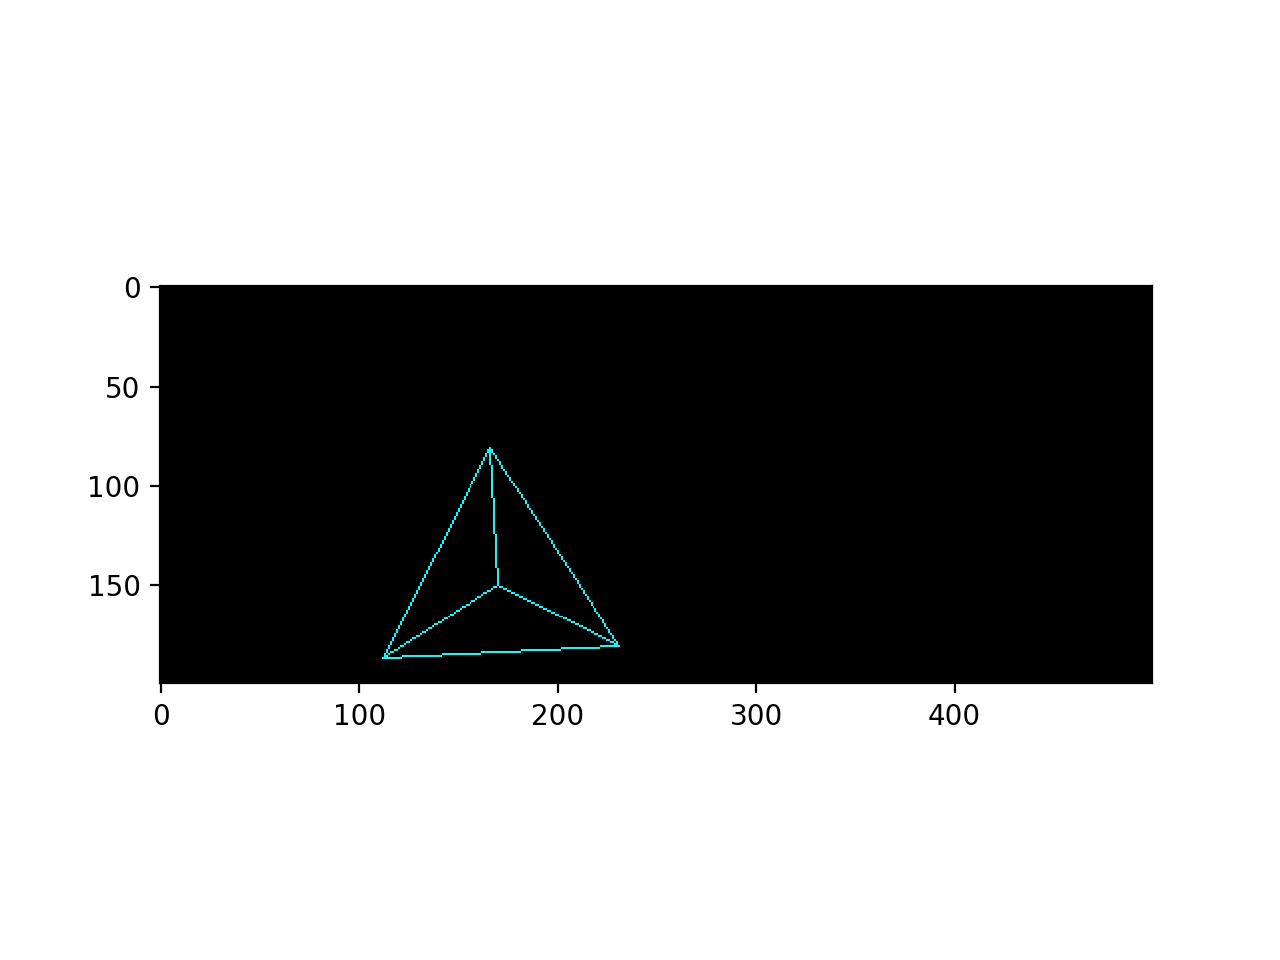

In [43]:
render(1)

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation


<IPython.core.display.Javascript object>


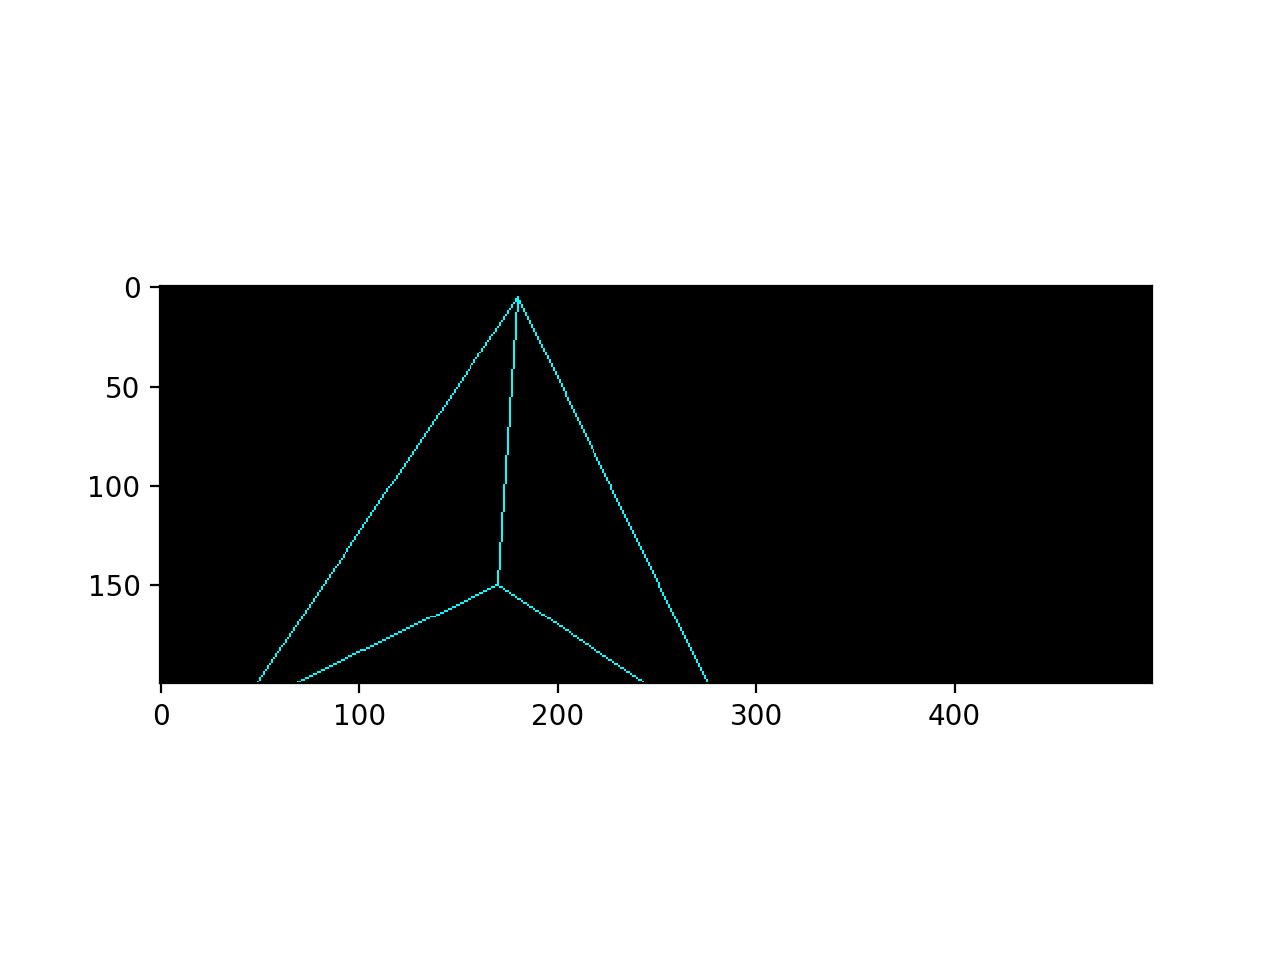

In [44]:
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    img = np.zeros((200,500,3), np.uint8)
    plt.imshow(img)

def update(frame):
    render(frame)

ani = FuncAnimation(fig, update, frames=np.linspace(1, 50, 400),
                    init_func=init, blit=False)
plt.show()

In [36]:
print(np.linspace(1, 50, 400))

[ 1.          1.12280702  1.24561404  1.36842105  1.49122807  1.61403509
  1.73684211  1.85964912  1.98245614  2.10526316  2.22807018  2.35087719
  2.47368421  2.59649123  2.71929825  2.84210526  2.96491228  3.0877193
  3.21052632  3.33333333  3.45614035  3.57894737  3.70175439  3.8245614
  3.94736842  4.07017544  4.19298246  4.31578947  4.43859649  4.56140351
  4.68421053  4.80701754  4.92982456  5.05263158  5.1754386   5.29824561
  5.42105263  5.54385965  5.66666667  5.78947368  5.9122807   6.03508772
  6.15789474  6.28070175  6.40350877  6.52631579  6.64912281  6.77192982
  6.89473684  7.01754386  7.14035088  7.26315789  7.38596491  7.50877193
  7.63157895  7.75438596  7.87719298  8.          8.12280702  8.24561404
  8.36842105  8.49122807  8.61403509  8.73684211  8.85964912  8.98245614
  9.10526316  9.22807018  9.35087719  9.47368421  9.59649123  9.71929825
  9.84210526  9.96491228 10.0877193  10.21052632 10.33333333 10.45614035
 10.57894737 10.70175439 10.8245614  10.94736842 11.0

In [37]:
import numpy as np
t = np.random.randn(5,4,3)

In [38]:
print(t.flatten())

[-0.39530124  0.08403852 -0.00636249  1.39539701  0.20938813  0.14372575
  0.16015876  0.60763517 -0.3402023  -0.45142715 -1.38397191  0.49405463
 -1.52053524  1.1632845   0.07673439  1.28537877  1.21206969 -2.21755503
 -1.40295402 -0.01476628 -0.84352165 -0.20435328  1.18825791 -0.82382836
  0.14576358  1.27238098  0.01804606  1.34521379  0.19022703 -2.59079441
  0.02578376 -1.95639826 -0.73575003  0.81586275 -1.37309349 -0.92479297
 -0.85519921 -0.63126155  0.12956163  0.50678188  0.20003933  1.4181193
 -1.27853414 -0.77764465  0.20354731  0.07899075  0.7892267   1.23420225
 -1.50468995 -0.41078085 -0.65666009  1.20130683  0.22856509  0.19902453
 -0.64410476 -1.01431225 -0.40704195 -2.01210719 -0.77424864 -1.60114978]


In [39]:
t = np.transpose(np.array(((1, 2, 3),(1,2,3))))
s = np.transpose(np.array([[1,1,1]]))
print(t.shape)
print(s.shape)
np.concatenate((t,s), axis=1)

(3, 2)
(3, 1)


array([[1, 1, 1],
       [2, 2, 1],
       [3, 3, 1]])